
Processing City Dataset...

Downloaded dataset.
Unzipping City dataset...
Extracted dataset.
Located `image_02` data folder for City at: ./kitti_data/City/2011_09_26/2011_09_26_drive_0001_sync/image_02/data
Expected frame count from timestamps file: 108

Running Redundancy Check for City (Week 2)...
Total duplicates found: 0

Running Completeness Check for City (Week 3)...
Expected frames: 108, Actual frames: 108
Missing frames: 0

Running Temporal Consistency Check for City (Week 4)...
Inconsistency detected between frame 0 and frame 1 with diff 116.01539237788514
Inconsistency detected between frame 1 and frame 2 with diff 119.11394167113974
Inconsistency detected between frame 2 and frame 3 with diff 115.15011844694936
Inconsistency detected between frame 5 and frame 6 with diff 116.27359169797818
Inconsistency detected between frame 6 and frame 7 with diff 121.26053820003578
Inconsistency detected between frame 7 and frame 8 with diff 124.61974378242978
Inconsistency detected betw

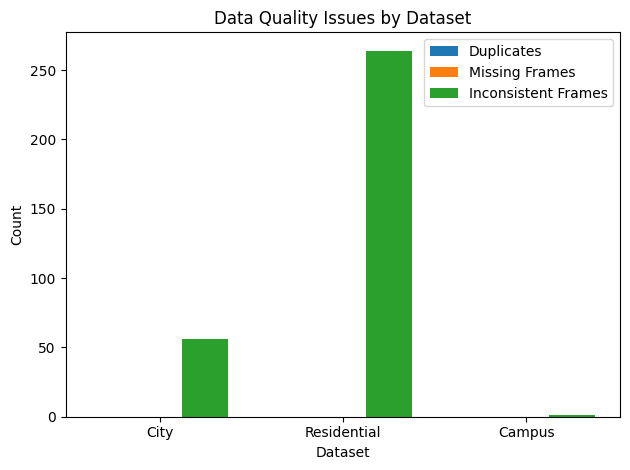

In [ ]:
import os
import cv2
import numpy as np
from hashlib import md5
import matplotlib.pyplot as plt

# Problem Statement:
# This code performs data quality checks on an autonomous driving dataset (various dataset from KITTI)
# to ensure the dataset is suitable for training and evaluation of machine learning models.
# Data quality issues like redundancy, completeness, temporal consistency are checked.
# These issues can impact model performance and must be addressed before using the dataset for model training.

datasets = {
    "City": "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data",
    "Residential": "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0019/2011_09_26_drive_0019_sync.zip",
    "Campus": "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0016/2011_09_28_drive_0016_sync.zip"
}
download_dir = "./kitti_data"
results = {}

# Downloading, Unzip, and Setup Paths for City Dataset
def download_and_extract_data(dataset_name, url):
    """Download and extract the dataset only if it hasn't been extracted already."""
    dataset_dir = os.path.join(download_dir, dataset_name)
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir, exist_ok=True)

    file_name = url.split('/')[-1]
    download_path = os.path.join(dataset_dir, file_name)

    # Download if not already downloaded
    if not os.path.exists(download_path):
        print(f"\nDownloading {file_name} for {dataset_name} dataset...")
        os.system(f"wget -O {download_path} {url}")
        print("Downloaded dataset.")
    else:
        print(f"\n{dataset_name} dataset already downloaded.")

    # Extract if not already extracted
    if not any(os.path.isdir(os.path.join(dataset_dir, d)) for d in os.listdir(dataset_dir)):
        print(f"Unzipping {dataset_name} dataset...")
        os.system(f"unzip -o {download_path} -d {dataset_dir}")
        print("Extracted dataset.")
    else:
        print(f"{dataset_name} dataset already unzipped.")

    # Locate `image_02/data` folder dynamically
    expected_data_folder = None
    for root, dirs, files in os.walk(dataset_dir):
        if 'image_02' in dirs:
            expected_data_folder = os.path.join(root, 'image_02', 'data')
            break

    if not expected_data_folder or not os.path.exists(expected_data_folder):
        raise FileNotFoundError(f"Could not locate the `image_02/data` folder for {dataset_name}. Please check the dataset structure.")

    print(f"Located `image_02` data folder for {dataset_name} at: {expected_data_folder}")
    return expected_data_folder



# Get the expected frame count from the timestamps file
def get_expected_frame_count(timestamps_file_path):
    """Reads the timestamps file to determine the expected number of frames."""
    if not os.path.exists(timestamps_file_path):
        raise FileNotFoundError(f"Timestamps file {timestamps_file_path} not found.")

    with open(timestamps_file_path, 'r') as f:
        frame_count = sum(1 for _ in f)
    print(f"Expected frame count from timestamps file: {frame_count}")
    return frame_count


# Redundancy Check: Detect Duplicate Images Using Hashing

# Redundancy:
# Redundancy in this dataset refers to duplicate images that do not provide additional information
# for the model and instead can lead to overfitting. This check identifies duplicate images
# based on hashing, where identical images will produce identical hash values.

def compute_image_hash(image):
    return md5(image.tobytes()).hexdigest()

def detect_duplicate_images(image_path):
    image_hashes = {}
    duplicates = []
    filenames = sorted(os.listdir(image_path), key=lambda x: int(x.split('.')[0]))

    for filename in filenames:
        filepath = os.path.join(image_path, filename)
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        img_hash = compute_image_hash(image)
        if img_hash in image_hashes:
            duplicates.append(filename)
        else:
            image_hashes[img_hash] = filename

    print(f"Total duplicates found: {len(duplicates)}")
    return duplicates



# Completeness Check: Ensure All Frames Are Present
# Completeness:
# Completeness ensures that all expected frames in a sequence are present in the dataset.
# Missing frames can lead to gaps in the data, potentially impacting the model's ability to learn
# smooth transitions or capture continuous events, which is crucial for autonomous driving data.

def check_completeness(image_path, expected_frame_count):
    actual_frame_count = len(os.listdir(image_path))
    missing_frames = expected_frame_count - actual_frame_count
    print(f"Expected frames: {expected_frame_count}, Actual frames: {actual_frame_count}")
    print(f"Missing frames: {missing_frames}")
    return missing_frames

def load_images_sorted(image_dir):
    sorted_filenames = sorted(os.listdir(image_dir), key=lambda x: int(x.split('.')[0]))
    images = [cv2.imread(os.path.join(image_dir, filename)) for filename in sorted_filenames]
    return images

# Temporal Consistency Check
# Temporal Consistency:
# Temporal consistency ensures that frames in a sequence are logically consistent over time.
# Large differences between consecutive frames could indicate issues in capturing smooth motion,
# leading to jerky or incorrect transitions that can affect the model’s perception of object movement.\

def check_temporal_consistency(images, threshold=115):
    inconsistent_frames = 0
    for i in range(1, len(images)):
        prev_image, curr_image = images[i - 1], images[i]
        diff = np.mean(np.abs(curr_image - prev_image))
        if diff > threshold:
            inconsistent_frames += 1
            print(f"Inconsistency detected between frame {i-1} and frame {i} with diff {diff}")

    print(f"Total inconsistent frames: {inconsistent_frames}")
    return inconsistent_frames

# Run quality checks for each dataset and store results
for dataset_name, url in datasets.items():
    print(f"\nProcessing {dataset_name} Dataset...")

    # Download and extract data
    image_dir = download_and_extract_data(dataset_name, url)

    # Get expected frame count from timestamps file
    timestamps_file = os.path.join(image_dir, '..', 'timestamps.txt')
    expected_frame_count = get_expected_frame_count(timestamps_file)

    # Redundancy Check
    print(f"\nRunning Redundancy Check for {dataset_name} (Week 2)...")
    duplicates = detect_duplicate_images(image_dir)

    # Completeness Check
    print(f"\nRunning Completeness Check for {dataset_name} (Week 3)...")
    missing_frames = check_completeness(image_dir, expected_frame_count)

    # Temporal Consistency Check
    print(f"\nRunning Temporal Consistency Check for {dataset_name} (Week 4)...")
    images = load_images_sorted(image_dir)
    inconsistent_frames = check_temporal_consistency(images)

    # Store results for plotting
    results[dataset_name] = {
        'Duplicates': duplicates,
        'Missing Frames': missing_frames,
        'Inconsistent Frames': inconsistent_frames
    }

    # Summary for each dataset
    print(f"\nSummary of Results for {dataset_name}:")
    print(f"Total duplicates found: {duplicates}")
    print(f"Total missing frames: {missing_frames}")
    print(f"Total inconsistent frames: {inconsistent_frames}")

# Preparing data for plotting
labels = list(results.keys())
duplicates = [results[dataset]['Duplicates'] if results[dataset]['Duplicates'] else 0 for dataset in labels]
missing_frames = [results[dataset]['Missing Frames'] for dataset in labels]
inconsistent_frames = [results[dataset]['Inconsistent Frames'] for dataset in labels]

# Ensure that all lists are of equal length
print(f"\nDebugging Info:")
print(f"Labels: {labels}")
print(f"Duplicates: {duplicates}")
print(f"Missing Frames: {missing_frames}")
print(f"Inconsistent Frames: {inconsistent_frames}")

# Check if lengths match
if not (len(duplicates) == len(missing_frames) == len(inconsistent_frames) == len(labels)):
    raise ValueError("Data lists for plotting have mismatched lengths. Check the quality check results for consistency.")

# Plotting the results
x = np.arange(len(labels))  # the label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, duplicates, width, label='Duplicates')
rects2 = ax.bar(x, missing_frames, width, label='Missing Frames')
rects3 = ax.bar(x + width, inconsistent_frames, width, label='Inconsistent Frames')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Data Quality Issues by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()
